# Fine tuning last layer of ResNet18

In [1]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,Cifar10DataModule, plot_loss_and_acc

In [2]:
entrypoints = torch.hub.list('pytorch/vision:v0.13.0', force_reload=True)
for e in entrypoints:
    if "resnet" in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /home/borja-dosuna/.cache/torch/hub/v0.13.0.zip
deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [3]:
pytorch_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', weights='IMAGENET1K_V1')

Using cache found in /home/borja-dosuna/.cache/torch/hub/pytorch_vision_v0.13.0


In [4]:
for param in pytorch_model.parameters():
    param.requires_grad = False
    
pytorch_model.fc = torch.nn.Linear(512, 10)

## Custom Transform

In [5]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
%%capture --no-display

L.pytorch.seed_everything(123)
# Use a bigger batch_size if you want full GPU VRAM utilization. With my settings, batch_size=1024 produces 10603MiB /  12227MiB 
dm = Cifar10DataModule(batch_size=64, num_workers=4, train_transform=preprocess_transform, test_transform=preprocess_transform)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=[0],
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [7]:
trainer.fit(model=lightning_model, datamodule=dm)

You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 11.2 M │ train │     0 │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 5.1 K                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


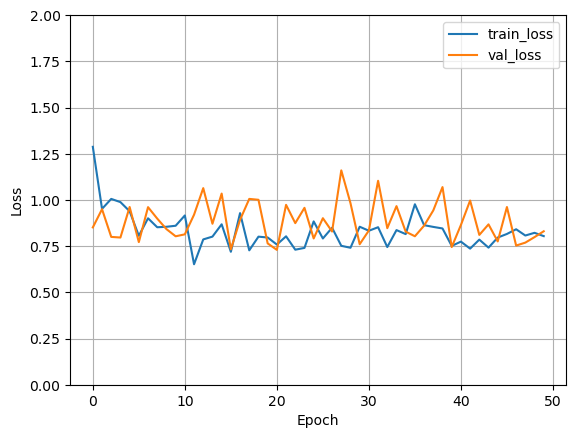

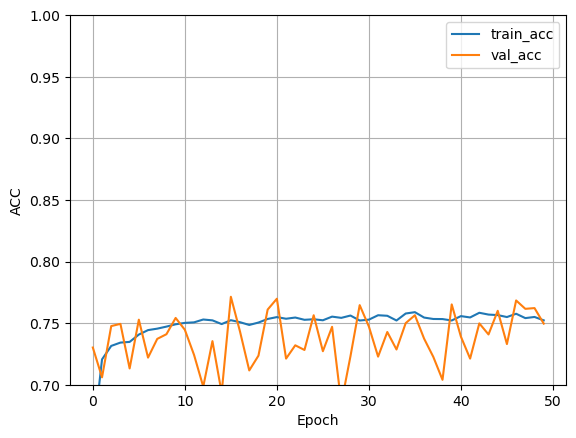

In [8]:
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0))

In [9]:
trainer.test(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7569000124931335     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7569000124931335}]